# SimCLR

Multi-backends version.

In [1]:
# %xmode minimal

import os
import json

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU devices
os.environ["TFDS_DATA_DIR"] = os.path.expanduser("~/tensorflow_datasets")  # default location of tfds database

# Turn off logging for TF
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import os
os.environ["KERAS_BACKEND"] = "jax"
# os.environ["KERAS_BACKEND"] = "torch"
# os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers, models

import tensorflow as tf
import tensorflow_datasets as tfds
tf.get_logger().setLevel(logging.ERROR)

import librosa
import librosa.display

import numpy as np
from matplotlib import pyplot as plt

from pathlib import Path

from IPython.display import Audio

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

from keras import layers, models, ops, losses, metrics

from keras.applications import resnet

# from keras.applications import vgg16

# tf.config.experimental_run_functions_eagerly(True)

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())


In [2]:
import dpmhm
# dpmhm.datasets.get_dataset_list()
from dpmhm.datasets import preprocessing, transformer, feature, utils
from dpmhm.models import simclr

workdir = Path("/home/han/tmp/SimCLR/")
os.makedirs(workdir, exist_ok=True)

## Load Data

In [3]:
ds_name = 'CWRU'

dpmhm.datasets.query_parameters(ds_name)

{'signal': {'DE': 1, 'FE': 1, 'BA': 1},
 'sampling_rate': [12000, 48000],
 'keys': {'FaultLocation': {'DriveEnd', 'FanEnd', 'None'},
  'FaultComponent': {'Ball',
   'InnerRace',
   'None',
   'OuterRace12',
   'OuterRace3',
   'OuterRace6'},
  'FaultSize': {0, 0.007, 0.014, 0.021, 0.028}},
 'filters': {'LoadForce': {0, 1, 2, 3}},
 'type': 'initiated',
 'split': ['train']}

In [4]:
ds0 = tfds.load(
    ds_name,
    # split='',
    # split=['train[:75%]', 'train[75%:]'],
    # split=[split1, split2],
    split='all',
    # download=True,  #
    # with_info=True,
    # batch_size=-1,  # load the whole dataset into a single batch
)

# ds0 = ds_all['train']
# ds_size = utils.get_dataset_size(ds0)

channels = ['DE', 'FE', 'BA']  # will rule out the normal data

keys = ['FaultComponent', 'FaultSize', 'FaultLocation']

# Feature extractor
_func = lambda x, sr: feature.spectral_features(
    x, sr, 'spectrogram',
    time_window=0.025,
    hop_step=0.0125,
    normalize=False,
    to_db=True)[0]

# _func = lambda x, sr: feature.spectral_features(
#     x, sr, 'melspectrogram',
#     time_window=0.025, hop_step=0.0125, normalize=False,
#     feature_kwargs={'n_mels':128})[0]

compactor = transformer.DatasetCompactor(ds0, keys=keys, channels=channels)
labels = list(compactor.full_label_dict.keys())

extractor = transformer.FeatureExtractor(compactor.dataset, _func)

# product = transformer.Product(specaugment.dataset, keys=['FileName'], positive=True)

# slider = transformer.WindowSlider(extractor.dataset, window_shape=64, downsample=64)
# # fp = tempfile.mkdtemp()
# # slider.serialize(str(workdir), compression='GZIP')
# slider.dataset = tf.data.Dataset.load(str(workdir), compression='GZIP')

# slider.dataset.cardinality()
# preproc = preprocessing.get_mapping_supervised(labels)
# ds1 = utils.restore_shape(
#     specaugment.dataset.map(preproc, num_parallel_calls=tf.data.AUTOTUNE)
# )

### SpecAugment and Paired dataset

For any spectral sample `x`, we apply the spectrogram augmentation provided in `transformer` and build a paired dataset of form `(x1, x2)` for SSL.

Notably, the paired dataset preserves randomness: a paired sample `(x1, x2)` is two randomly transformed version of a common `x`. Let's check this.

Alternatively, the spectrogram augmentation can be implemented also via keras preprocessing layers as follows 

```python
layer_zoom = keras.layers.RandomZoom((-.5,.5), fill_mode='reflect')
layer_flip = keras.layers.RandomFlip(mode='horizontal')
layer_crop = keras.layers.RandomCrop(64, 64)

layer_flip(layer_crop(layer_zoom(X)))
```

In [5]:
specaugment = transformer.SpecAugment(
    extractor.dataset,
    output_shape=(64,64),
    blur_kwargs={'prob':0},
    fade_kwargs={'prob':0},
    flip_kwargs={'prob':0}
)

# eles = list(extractor.dataset.take(10).as_numpy_iterator())
# plt.imshow(eles[1]['feature'][0])

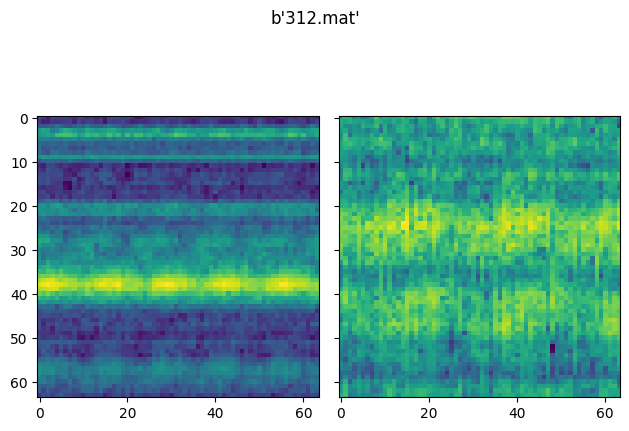

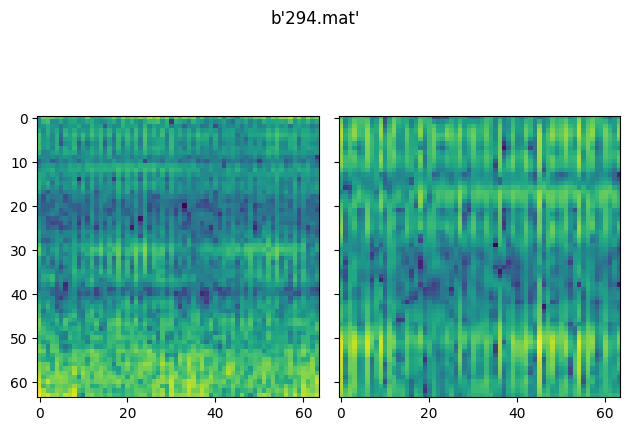

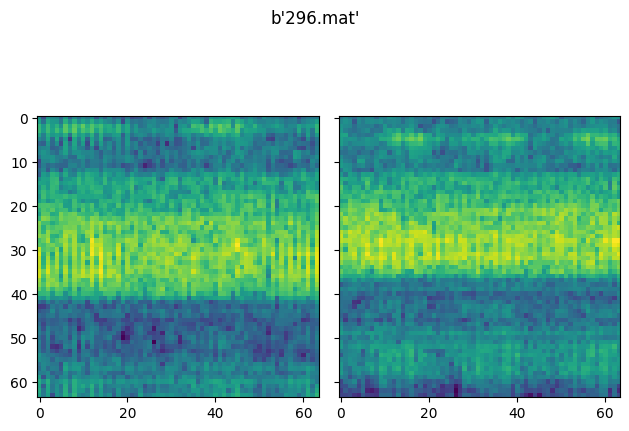

In [6]:
ds1 = specaugment.dataset
# Paired dataset
ds2 = tf.data.Dataset.zip(ds1, ds1)

for e1, e2 in ds2.take(3):
    assert(e1['metadata']==e2['metadata'])
    X1 = e1['feature'][0]
    X2 = e2['feature'][0]

    fig, axes = plt.subplots(1,2,sharey=True)
    axes[0].imshow(X1)
    axes[1].imshow(X2)
    fig.suptitle(e1['metadata']['FileName'].numpy())
    fig.tight_layout()

### Dataset with fake labels

The paired dataset of element type `(x1, x2)` passed to the SimCLR model will be transformed to `(y1, y2)`. Unfortunately the later incompatible with the loss function `loss(y_true, y_pred)` accepted by Keras. Actually, there is no `y_true` in our case and `y_pred` should be `(y1, y2)`. 

One solution (also put forward by the official documentation of Keras) is to customize the method `train_step()` which is backend dependent, like in

https://keras.io/guides/custom_train_step_in_tensorflow/

 A simpler solution avoids the customization and only needs to adapt `call()` and the loss function, like follows

1. From the original paired dataset build a dataset of type `((x1, x2), fake_label)` as input to the SimCLR model's `.call()`. Optionally the part `(x1, x2)` can be stacked in a single tensor (possibly of higher dimension) to avoid any implicite compile time error, using `.map()` on `tf.stack([x1, x2])`.
2. In `.call(inputs)` separate `x1` and `x2` from `inputs` as `x1, x2 = inputs[0], inputs[1]`. This is safer than `x1, x2 = inputs` which may complain when use Tensorflow as backend. For stacked inputs, use instead `ops.take()`. On the other hand, the output of `.call()` must be a single tensor like `ops.stack([y1, y2])`.
3. The loss function's signature is always `loss(y_true, y_pred)`, although it doesn't use the fake label `y_true` at all. `y1` and `y2` needed by the original loss are obtained again by splitting `y_pred` using `ops.take()`. 

Then one can call `model.fit()` on the dataset `((x1, x2), fake_label)` for training, independant of the backend.

The logic behind this solution is that the `Model` class in Keras is actually designed for supervised learning, of type `y=f(x)`. A customized Keras model implements `f` in the method `.call(x)`, which should not be confused with `.fit(x,y)`. The argument `inputs` to `.call(inputs)` can be a tuple, but the output has to be a single tensor (if the output has several terms then only the first is passed to the loss function). The type of dataset passed to `model.fit()` has always to be `(x,y)`: no matter how many actual terms in `x` (and `y`), they need to be packed in a single tensor properly. The loss function takes `(y_true, y_pred)` with `y_true` from the dataset and `y_pred` from the output of `.call()`. Any deviation from this setting should be adapted, like the solution outlined above.

Let's remove all irrelevant information and keep only the field `'feature'`, and make a ready-to-use paired dataset with a fake label.

In [7]:
# To channel last format
ds1 = utils.restore_shape(
    specaugment.dataset.map(lambda x: tf.transpose(x['feature'], [1,2,0]), num_parallel_calls=tf.data.AUTOTUNE),
)
input_shape = ds1.element_spec.shape

# Paired dataset
ds2 = tf.data.Dataset.zip(ds1, ds1)
# ds2 = tf.data.Dataset.zip(ds1, ds1, ds1)  # or even more...
# eles = list(ds2.take(10).as_numpy_iterator())

ds2.element_spec
# ds2_size = utils.get_dataset_size(ds2)
# ds2 = ds2.apply(tf.data.experimental.assert_cardinality(ds2_size))

(TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None))

In [8]:
# Construct a dataset with fake labels, following the logic of Keras
def func(cst):
    def _gen():
        while True:
            yield cst
    return _gen

dg = tf.data.Dataset.from_generator(func(None), output_types=tf.float32, output_shapes=())
# dg = tf.data.Dataset.from_generator(func(1.), output_signature=tf.TensorSpec(shape=(None)))  # equivalent

# list(dg.take(10))
# or `list(dg.repeat().take(10))` if no `while` loop in the generator.

ds = tf.data.Dataset.zip(ds2, dg)

Equivalently, just use the provided method `utils.twins_dataset_ssl()`.

In [9]:
ds, input_shape = utils.twins_dataset_ssl(specaugment.dataset, stack=False, fake_label=True)

ds.element_spec

((TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None)),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

In [10]:
ds = utils.restore_cardinality(ds)
ds_size = int(ds.cardinality())  # utils.get_dataset_size(ds)

ds_size

97

## SimCLR model

In [11]:
splits = {'train':0.7, 'val':0.2, 'test':0.1}

ds_split = utils.split_dataset(ds, splits, ds_size=ds_size)

batch_size = 10

ds_train = ds_split['train']\
    .shuffle(ds_size, reshuffle_each_iteration=True)\
    .batch(batch_size, drop_remainder=True)\
    .prefetch(tf.data.AUTOTUNE)
ds_val = ds_split['val'].batch(batch_size, drop_remainder=True)
ds_test = ds_split['test'].batch(1, drop_remainder=True)

ds_train.element_spec

((TensorSpec(shape=(10, 64, 64, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(10, 64, 64, 3), dtype=tf.float32, name=None)),
 TensorSpec(shape=(10,), dtype=tf.float32, name=None))

In [13]:
# encoder_kwargs = dict(include_top=False, weights='imagenet', pooling='max')
encoder_kwargs = dict(include_top=False, weights=None, pooling='max')

model = dpmhm.models.simclr.SimCLR(input_shape, name='VGG16', tau=0.1, **encoder_kwargs)
model._encoder.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(),
)

model.summary()

Model: "sim_clr_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_5 (Functional)       │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ projector (Sequential)          │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
hh = model.fit(ds_train,
               validation_data=ds_val,
               epochs=100)

plt.plot(hh.history['loss'])

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 3808.3286 - val_loss: 4235.5327
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 3997.4966 - val_loss: 4143.6196
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 4046.0840 - val_loss: 4015.8274
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 4094.8938 - val_loss: 4229.5527
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 4006.1570 - val_loss: 4207.2896
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 3970.4863 - val_loss: 4135.1265
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 3993.7686 - val_loss: 4236.7026
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 3970.8979 - val_loss: 4207.3057
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 3711.1777 - val_loss: 4069.2175
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 3979.8518 - val_loss: 3862.3052
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 4005.1914 - val_loss: 4170.6118
Epoch 12/100
6/6 ━━

KeyboardInterrupt: 

### Supervised fine tuning

From the trained SimCLR model, we extract the feature transformation part which includes the base encoder and the first two dense layers of the projection head. 

In [25]:
x = layers.Input(input_shape)

# same same
# _proj = models.Model(inputs=model._projector.inputs, outputs=model._projector.layers[3].output)
_proj = models.Model(inputs=model._projector.layers[0].input, outputs=model._projector.layers[3].output)

# _proj.summary()  # shows a concrete value for batch

f = _proj(model._encoder(x))

model_feature = models.Model(inputs=x, outputs=f, name='SimCLR_feature')

model_feature.summary()  # shows `None` for batch

Model: "SimCLR_feature"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_2 (Functional)       │ (None, 256)            │     9,457,920 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,045,632 (126.06 MB)

 Trainable params: 32,984,320 (125.83 MB)

 Non-trainable params: 61,312 (239.50 KB)

#### Classfication head and fine tuning

We add a classification head to the feature transformation network and fine tune the model on some new data.

In [26]:
window = transformer.WindowSlider(extractor.dataset, window_size=(64,64), hop_size=(64,64))
# fp = tempfile.mkdtemp()
# window.serialize(str(workdir), compression='GZIP')
# window.dataset = tf.data.Dataset.load(str(workdir), compression='GZIP')

preproc = preprocessing.get_mapping_supervised(labels)

splits = {'train':0.7, 'val':0.2, 'test':0.1}
batch_size = 64

n_classes = len(labels) + 1

In [30]:
dw = utils.restore_shape(
    window.dataset.map(preproc, num_parallel_calls=tf.data.AUTOTUNE),
    key=0
)

dw_size = utils.get_dataset_size(dw)

dw_split = utils.split_dataset(
    dw, splits, 
    # ds_size=dw_size, 
    # labels=np.arange(n_classes)
)

dw_train = dw_split['train']\
    .shuffle(dw_size, reshuffle_each_iteration=True)\
    .batch(batch_size, drop_remainder=True)\
    .prefetch(tf.data.AUTOTUNE)
dw_val = dw_split['val'].repeat().batch(batch_size, drop_remainder=True)
dw_test = dw_split['test'].batch(batch_size, drop_remainder=True)

The classification head here is a simple MLP. The weights of the feature transformation network are frozen for the training.

In [31]:
model_feature.trainable = False

class_head = models.Sequential([
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(n_classes) # nb labels
], name='Classification_head')

x = layers.Input(input_shape)

model_fine = models.Model(inputs=x, outputs=class_head(model_feature(x)))

model_fine.compile(
    optimizer=keras.optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

In [32]:
hh = model_fine.fit(
    dw_train,
    validation_data=dw_val,
    epochs=10
)

Epoch 1/10
    912/Unknown 302s 325ms/step - loss: 2.9132 - sparse_categorical_accuracy: 0.0917

KeyboardInterrupt: 

In [28]:
model_fine.evaluate(dw_test)

2024-06-18 22:14:38.280661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.2115 - sparse_categorical_accuracy: 0.9405

2024-06-18 22:14:45.099446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 284ms/step - loss: 0.2106 - sparse_categorical_accuracy: 0.9409


[0.19973041117191315, 0.9449999928474426]

### Few-shot learning

In few-shot learning the number of new data per category is limited. We can prepare the data for few-shot learning by splitting separately data of each category.

However for unknown reasons, the performance of the few-shot split seems to be very low compared to the normal split.

In [80]:
window = transformer.WindowSlider(
    extractor.dataset, 
    window_size=(64,64), 
    hop_size=(64, 64)
    # hop_size=(32, 32)
)

preproc = preprocessing.get_mapping_supervised(labels)

splits = {'train':0.2, 'val':0.7, 'test':0.1}
batch_size = 64

n_classes = len(labels) + 1

In [ ]:
# Only for demonstration, here we apply the preprocessing after the split.
dw_split = utils.split_dataset(
    dw, splits, 
    labels=labels
)

for k, dv in dw_split.items():
    dv.save(str(workdir/f'fs_split_{k}'))

In [94]:
dw_split = {}
for k in splits.keys():
    dw_split[k] = tf.data.Dataset.load(str(workdir/f'fs_split_{k}'))

In [116]:
dw_train = dw_split['train']\
    .map(preproc, num_parallel_calls=tf.data.AUTOTUNE)\
    .shuffle(1000, reshuffle_each_iteration=True)\
    .batch(batch_size, drop_remainder=True)\
    .prefetch(tf.data.AUTOTUNE)
dw_val = dw_split['val']\
    .map(preproc, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(batch_size, drop_remainder=True)
dw_test = dw_split['test']\
    .map(preproc, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(batch_size, drop_remainder=True)

In [118]:
%time eles = list(dw_train.take(10))

CPU times: user 172 ms, sys: 13.4 ms, total: 185 ms
Wall time: 58.7 ms


2024-06-18 23:51:57.085419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
eles[0][0]

In [ ]:
model_feature(eles[0][0])

In [101]:
model_feature.trainable = False

class_head = models.Sequential([
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(n_classes) # nb labels
], name='Classification_head')

x = layers.Input(input_shape)

model_fs = models.Model(inputs=x, outputs=class_head(model_feature(x)))

model_fs.compile(
    optimizer=keras.optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

In [102]:
hh = model_fs.fit(
    dw_train,
    validation_data=dw_val,
    epochs=10
)

RuntimeError: Unable to automatically build the model. Please build it yourself before calling fit/evaluate/predict. A model is 'built' when its variables have been created and its `self.built` attribute is True. Usually, calling the model on a batch of data is the right way to build it.
Exception encountered:
'Exception encountered when calling Conv2D.call().

[1m'NoneType' object is not callable[0m

Arguments received by Conv2D.call():
  • inputs=jnp.ndarray(shape=(64, 70, 70, 3), dtype=float32)'

In [ ]:
model_fs.evaluate(dw_test)

2024-06-18 23:41:21.174297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:41:22.954204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:41:24.714093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:41:26.471666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:41:28.231720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:41:30.062777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:41:31.896178: W tensorflow/core/framework/local_rendezvous.cc:404] L

# EOF

Test the feature transformation model to see how it acts across the batch.

In [ ]:
# eles = list(ds_train.take(1))[0]
eles = list(ds_train.take(1).as_numpy_iterator())[0]

xx = ops.take(eles[0][0], [2], axis=0)
yy = model_feature.predict(xx)  # apply on a single input
zz = model_feature.predict(eles[0][0])[2]  # apply on a batch of inputs then take the corresponding output

# yy = model._encoder.predict(xx)
# zz = model._encoder.predict(eles[0][0])[2]

# Comparison: NOT zero.
np.abs(yy-zz)